In [ ]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 41.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 74.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.3/48.3 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 71.2 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.10.1
    Uninstalling scipy-1.10.1:
      Successfully uninstalled scipy-1.10.1
  Attempting uninstall: autograd
    Found existing installation: autograd 1.6.1
    Uninstalling autograd-1.6.1:
      Successfully uninstalled autograd-1.6.1


In [ ]:
import qlstm_cell

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from qlstm_cell import QLSTMCell
import numpy as np
import time

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
df = pd.read_csv("balans1.csv")
df = df.dropna()

# convert class name
X = df["text"].to_list()
y = df["label"].to_list()

df.head()

,text,label
0,Kvitka Tsysyk Street,2.0
1,PE,1.0
2,Private joint-stock company Kyivmiskbud,0.0
3,Water inlets to a residential building,0.0
4,Pravda Avenue,2.0


In [ ]:
tokens = [x_i.split(" ") for x_i in X]

word_to_ix = {0: 0}  # padding idx
# For each words-list (sentence) and tags-list in each tuple of training_data
for sent in tokens:
    for word in sent:
        if word not in word_to_ix:  # word has not been assigned an index yet
            word_to_ix[word] = len(word_to_ix)  # Assign each word with a unique index
vocab_size = len(word_to_ix.keys())
print(f"Vocab size: {vocab_size}")

Vocab size: 55


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42
)

print(f"Train: {len(y_train)}; Val: {len(y_val)}; Test: {len(y_test)}")

Train: 715; Val: 80; Test: 199


In [ ]:
class SentimentDataset(Dataset):
    def __init__(self, X, y, to_ix: dict, device):
        self.X = X
        self.y = y
        self.to_ix = to_ix

        # transform text to ix in vocab
        self.X_ix = [self._transform_to_ix(x_i.split(" ")) for x_i in X]
        # pad sequences to same length
        pad_len = len(max(self.X_ix, key=len))
        self.X_pad = self._pad_seq(self.X_ix, pad_len)
        # to tensor
        self.X_t = torch.LongTensor(self.X_pad).to(device)

        # transform labels to tensors
        self.y_t = torch.LongTensor(y).to(device)

    def _transform_to_ix(self, seq):
        idxs = [self.to_ix[w] for w in seq]
        return idxs

    def _pad_seq(self, X, length: int):
        padded = []
        for row in X:
            p = np.pad(row, (0, length - len(row))).tolist()
            padded.append(p)
        return np.asarray(padded, dtype=np.int32)

    def __len__(self):
        return len(self.y_t)

    def __getitem__(self, idx):
        return self.X_t[idx], self.y_t[idx]

In [ ]:
batch_size = 64

dataset_train = SentimentDataset(X_train, y_train, word_to_ix, device)
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

dataset_val = SentimentDataset(X_val, y_val, word_to_ix, device)
val_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)

dataset_test = SentimentDataset(X_test, y_test, word_to_ix, device)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

In [ ]:
class LSTMClassifier(nn.Module):
    def __init__(
        self,
        embedding_dim: int = 8,
        hidden_dim: int = 32,
        vocab_size: int = 100,
        output_size: int = 2,
        n_qubits: int = 4,
        n_qlayers: int = 1,
        qml_device: str = "default.qubit",
        learning_rate: float = 0.1,
        n_epochs: int = 300,
        batch_size: int = 1,
        linear_dropout: float = 0.1,
        rnn_dropout: float = 0.1,
        rnn_layers: int = 1,
        weight_decay: float = 1e-5,
        momentum: float = 0.9,
        rnn: str = "lstm",
        rnn_bidirectional: bool = False,
        torch_device=torch.device("cpu"),
    ):
        super(LSTMClassifier, self).__init__()
        # params
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.output_size = output_size
        self.n_qubits = n_qubits
        self.n_qlayers = n_qlayers
        self.batch_size = batch_size
        self.rnn_dropout = rnn_dropout
        self.linear_dropout = linear_dropout
        self.n_epochs = n_epochs
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.rnn_layers = rnn_layers
        self.rnn_bidirectional = rnn_bidirectional
        self.qml_device = qml_device
        self.torch_device = torch_device

        # init word embeddings
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        if rnn == "qlstm":
            print("Model will use Quantum LSTM")
            self.lstm = QLSTMCell(
                self.embedding_dim,
                hidden_dim,
                n_qubits=self.n_qubits,
                n_qlayers=self.n_qlayers,
                qml_device=self.qml_device,
                torch_device=self.torch_device,
            )
        elif rnn == "lstm":
            print("Model will use Classical LSTM")
            self.lstm = nn.LSTM(
                self.embedding_dim,
                hidden_dim,
                batch_first=True,
                num_layers=rnn_layers,
                dropout=self.rnn_dropout,
                bidirectional=rnn_bidirectional,
            )
        elif rnn == "gru":
            print("Model will use Classical GRU")
            self.lstm = nn.GRU(
                self.embedding_dim,
                hidden_dim,
                batch_first=True,
                num_layers=rnn_layers,
                dropout=self.rnn_dropout,
                bidirectional=rnn_bidirectional,
            )
        else:
            raise ValueError("Invalid rnn layer")

        self.D = 2 if rnn_bidirectional else 1  # lstm bidirectional hidden states
        self.hidden_layers = nn.Sequential(
            nn.Linear(self.D * hidden_dim, self.D * hidden_dim), nn.ReLU()
        )

        # The linear layer that maps from hidden state space to tag space
        self.label = nn.Linear(self.D * hidden_dim, output_size)

        self.optimizer = optim.RMSprop(
            self.parameters(),
            lr=learning_rate,
            weight_decay=weight_decay,
            momentum=momentum,
        )
        self.lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, "min")

        self.loss_function = nn.NLLLoss()
        self.dropout = nn.Dropout(p=self.linear_dropout)

    def forward(self, sentence):
        # transform from word indices to word embeddings
        embeds = self.word_embeddings(sentence)

        # pass through lstm layers
        lstm_out, _ = self.lstm(embeds)
        out = lstm_out[:, -1, :]  # last hidden state of lstm output

        # hidden layers
        out = self.hidden_layers(out)

        # apply dropout
        out = self.dropout(out)

        # cast to number of classes
        logits = self.label(out)

        # cast to log softmax probabilities
        log_probs = F.log_softmax(logits, dim=-1)
        return log_probs

    def fit(self, train_loader: DataLoader, val_loader: DataLoader):
        self.history = {
            "train/loss": [],
            "train/acc": [],
            "val/loss": [],
            "val/acc": [],
        }

        # iterate epochs
        for epoch in range(self.n_epochs):
            self.train()  # set train mode
            losses = []
            preds = []
            targets = []

            # iterate batches
            for i, (sentence, label) in enumerate(train_loader):
                # Step 1. Remember that Pytorch accumulates gradients.
                # We need to clear them out before each instance
                self.optimizer.zero_grad()

                # Step 2. Run our forward pass.
                y_hat = self(sentence)

                # Step 3. Compute the loss, gradients, and update the parameters by
                #  calling optimizer.step()
                loss = self.loss_function(y_hat, label)
                loss.backward()
                self.optimizer.step()
                losses.append(float(loss))
                preds.append(y_hat.argmax(dim=-1))
                targets.append(label)

            avg_loss = np.mean(losses)
            self.history["train/loss"].append(avg_loss)

            preds = torch.cat(preds)
            targets = torch.cat(targets)
            corrects = preds == targets
            accuracy = corrects.sum().float() / float(targets.size(0))
            self.history["train/acc"].append(accuracy)

            # calc validation loss and accuracy
            val_loss, val_acc = self._validate(val_loader)

            print(
                f"Epoch {epoch+1} / {self.n_epochs}: train/Loss = {avg_loss:.3f} val/Loss = {val_loss:.3f} train/Acc = {accuracy:.2f} val/Acc = {val_acc:.2f}"
            )

    def _validate(self, val_loader: DataLoader):
        self.eval()  # set eval mode
        y_hat = []
        y_pred = []
        y_true = []

        # iterate batches and predict on val set
        for X_val, y_val in val_loader:
            probs = self(X_val)
            y_hat.append(probs)
            y_pred.append(probs.argmax(dim=-1))
            y_true.append(y_val)

        y_hat = torch.cat(y_hat)
        y_pred = torch.cat(y_pred)
        y_true = torch.cat(y_true)
        corrects = y_pred == y_true
        val_acc = corrects.sum().float() / float(y_true.size(0))
        val_loss = float(self.loss_function(y_hat, y_true))

        self.history["val/loss"].append(val_loss)
        self.history["val/acc"].append(val_acc)

        return val_loss, val_acc

    def predict(self, test_loader):
        self.eval()
        y_pred = []
        for X, _ in test_loader:
            y_hat = self(X)
            preds = torch.argmax(y_hat, axis=1).cpu().numpy().tolist()
            y_pred.extend(preds)
        return y_pred

In [ ]:
from matplotlib.ticker import MaxNLocator


def plot_training(history, show=True):
    fig, ax1 = plt.subplots()

    # move tensors to cpu device
    history["train/acc"] = [t.cpu() for t in history["train/acc"]]
    history["val/acc"] = [t.cpu() for t in history["val/acc"]]

    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    x_range = range(1, len(history["train/loss"]) + 1)  # correct x ticks
    line1 = ax1.plot(x_range, history["train/loss"], color="orange", label="Train loss")
    line2 = ax1.plot(
        x_range, history["val/loss"], color="red", linestyle="dashed", label="Val loss"
    )

    ax2 = ax1.twinx()
    ax2.set_ylabel("Accuracy")
    line3 = ax2.plot(
        x_range, history["train/acc"], color="steelblue", label="Train accuracy"
    )
    line4 = ax2.plot(
        x_range,
        history["val/acc"],
        color="blue",
        linestyle="dashed",
        label="Val accuracy",
    )

    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

    fig.tight_layout()
    # Shrink current axis by 20%
    box = ax1.get_position()
    ax1.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    lines = line1 + line2 + line3 + line4
    legend_labels = [l.get_label() for l in lines]
    ax1.legend(lines, legend_labels, loc="upper left", bbox_to_anchor=(1.3, 0.7))

    fig.savefig(f"{rnn}_{n_qlayers}_{n_qubits}.pdf")
    if show:
        fig.show()

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef, roc_auc_score
from sklearn.preprocessing import label_binarize


def eval_metrics(y_test, y_pred):
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="weighted")

    # binarize labels for multi class auc score
    labels = list(set(y_test))
    y_test_bin = label_binarize(y_test, classes=labels)
    y_pred_bin = label_binarize(y_pred, classes=labels)
    auc = roc_auc_score(y_test_bin, y_pred_bin, average="weighted", multi_class="ovo")

    mcc = matthews_corrcoef(y_test, y_pred)
    return acc, f1, auc, mcc

In [ ]:
embedding_dim = 10
hidden_dim = 16
output_size = len(np.unique(y))
n_epochs = 20
n_qubits = 4
n_qlayers = 1
learning_rate = 1e-2
linear_dropout = 0 # dropout for linear layers
rnn_dropout = 0 # dropout for classical rnn layers
rnn_layers = 1 # number of classical rnn layers
weight_decay = 1e-4 # weight decay for optimizer / l2 regularization
momentum = 0 # momentum for optimizer
rnn = "lstm" # rnn layer -> lstm/qlstm/gru
rnn_bidirectional = False # bidirectionality for classical rnn layer

model = LSTMClassifier(
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    vocab_size=vocab_size,
    output_size=output_size,
    n_epochs=n_epochs,
    learning_rate=learning_rate,
    linear_dropout=linear_dropout,
    rnn_dropout=rnn_dropout,
    rnn_layers=rnn_layers,
    batch_size=batch_size,
    weight_decay=weight_decay,
    momentum=momentum,
    rnn=rnn,
    rnn_bidirectional=rnn_bidirectional,
    n_qubits=n_qubits,
    n_qlayers=n_qlayers,
    torch_device=device,
)
model.to(device)

# start training and track time
start_time = time.time()

model.fit(train_loader, val_loader)

training_time = round(time.time() - start_time, 2)
print(f"Training time: {training_time}sec")

Model will use Classical LSTM
Epoch 1 / 20: train/Loss = 0.690 val/Loss = 0.459 train/Acc = 0.68 val/Acc = 0.76
Epoch 2 / 20: train/Loss = 0.222 val/Loss = 0.058 train/Acc = 0.90 val/Acc = 0.99
Epoch 3 / 20: train/Loss = 0.016 val/Loss = 0.048 train/Acc = 1.00 val/Acc = 0.99
Epoch 4 / 20: train/Loss = 0.010 val/Loss = 0.050 train/Acc = 1.00 val/Acc = 0.99
Epoch 5 / 20: train/Loss = 0.004 val/Loss = 0.031 train/Acc = 1.00 val/Acc = 0.99
Epoch 6 / 20: train/Loss = 0.001 val/Loss = 0.036 train/Acc = 1.00 val/Acc = 0.99
Epoch 7 / 20: train/Loss = 0.001 val/Loss = 0.041 train/Acc = 1.00 val/Acc = 0.99
Epoch 8 / 20: train/Loss = 0.001 val/Loss = 0.044 train/Acc = 1.00 val/Acc = 0.99
Epoch 9 / 20: train/Loss = 0.001 val/Loss = 0.048 train/Acc = 1.00 val/Acc = 0.99
Epoch 10 / 20: train/Loss = 0.001 val/Loss = 0.051 train/Acc = 1.00 val/Acc = 0.99
Epoch 11 / 20: train/Loss = 0.000 val/Loss = 0.053 train/Acc = 1.00 val/Acc = 0.99
Epoch 12 / 20: train/Loss = 0.000 val/Loss = 0.054 train/Acc = 1.0

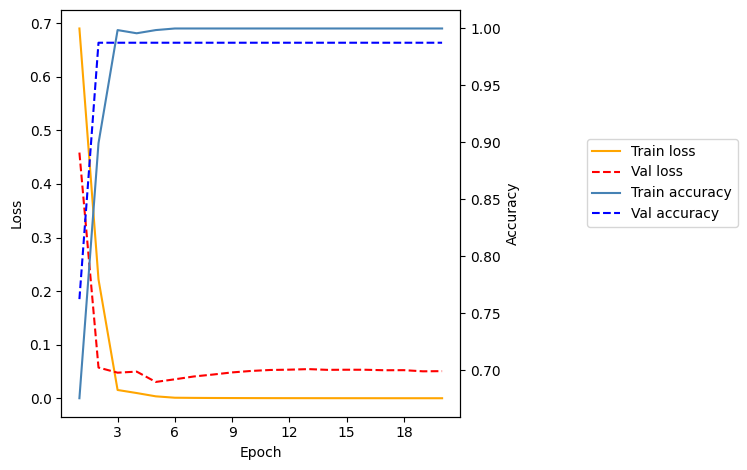

In [ ]:
plot_training(model.history)

In [ ]:
y_pred = model.predict(test_loader)

acc, f1, auc, mcc = eval_metrics(y_test, y_pred)
print(f"Acc: {acc}, F1: {f1}, AUC: {auc}, MCC: {mcc}")

Acc: 1.0, F1: 1.0, AUC: 1.0, MCC: 1.0


In [ ]:
embedding_dim = 10
hidden_dim = 16
output_size = len(np.unique(y))
n_epochs = 20
n_qubits = 4
n_qlayers = 1
learning_rate = 1e-2
linear_dropout = 0 # dropout for linear layers
rnn_dropout = 0 # dropout for classical rnn layers
rnn_layers = 1 # number of classical rnn layers
weight_decay = 1e-4 # weight decay for optimizer / l2 regularization
momentum = 0 # momentum for optimizer
rnn = "qlstm" # rnn layer -> lstm/qlstm/gru
rnn_bidirectional = False # bidirectionality for classical rnn layer

model = LSTMClassifier(
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    vocab_size=vocab_size,
    output_size=output_size,
    n_epochs=n_epochs,
    learning_rate=learning_rate,
    linear_dropout=linear_dropout,
    rnn_dropout=rnn_dropout,
    rnn_layers=rnn_layers,
    batch_size=batch_size,
    weight_decay=weight_decay,
    momentum=momentum,
    rnn=rnn,
    rnn_bidirectional=rnn_bidirectional,
    n_qubits=n_qubits,
    n_qlayers=n_qlayers,
    torch_device=device,
)
model.to(device)

# start training and track time
start_time = time.time()

model.fit(train_loader, val_loader)

training_time = round(time.time() - start_time, 2)
print(f"Training time: {training_time}sec")

Model will use Quantum LSTM
weight_shapes = (n_qlayers, n_qubits) = (1, 4)
Epoch 1 / 20: train/Loss = 0.859 val/Loss = 0.560 train/Acc = 0.58 val/Acc = 0.79
Epoch 2 / 20: train/Loss = 0.426 val/Loss = 0.361 train/Acc = 0.81 val/Acc = 0.81
Epoch 3 / 20: train/Loss = 0.264 val/Loss = 0.179 train/Acc = 0.90 val/Acc = 0.99
Epoch 4 / 20: train/Loss = 0.057 val/Loss = 0.020 train/Acc = 1.00 val/Acc = 1.00
Epoch 5 / 20: train/Loss = 0.014 val/Loss = 0.010 train/Acc = 1.00 val/Acc = 1.00
Epoch 6 / 20: train/Loss = 0.007 val/Loss = 0.006 train/Acc = 1.00 val/Acc = 1.00
Epoch 7 / 20: train/Loss = 0.005 val/Loss = 0.004 train/Acc = 1.00 val/Acc = 1.00
Epoch 8 / 20: train/Loss = 0.003 val/Loss = 0.002 train/Acc = 1.00 val/Acc = 1.00
Epoch 9 / 20: train/Loss = 0.002 val/Loss = 0.002 train/Acc = 1.00 val/Acc = 1.00
Epoch 10 / 20: train/Loss = 0.001 val/Loss = 0.001 train/Acc = 1.00 val/Acc = 1.00
Epoch 11 / 20: train/Loss = 0.001 val/Loss = 0.001 train/Acc = 1.00 val/Acc = 1.00
Epoch 12 / 20: train/

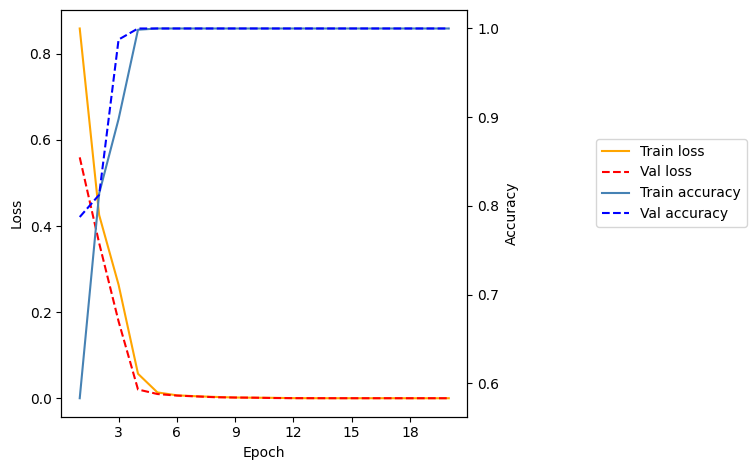

In [ ]:
plot_training(model.history)

In [ ]:
y_pred = model.predict(test_loader)

acc, f1, auc, mcc = eval_metrics(y_test, y_pred)
print(f"Acc: {acc}, F1: {f1}, AUC: {auc}, MCC: {mcc}")

Acc: 1.0, F1: 1.0, AUC: 1.0, MCC: 1.0


In [ ]:
!pip install lambeq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.8/142.8 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.9/144.9 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 55.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.3/364.3 kB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 71.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.5/103.5 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 73.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 56.5 MB/s eta 0:00:00


In [ ]:
!pip install discopy

In [ ]:
!pip install pytket-qiskit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 3.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 75.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.8/233.8 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 43.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.5/241.5 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━

In [ ]:
import warnings

warnings.filterwarnings("ignore")
import os
import numpy as np
import pandas as pd

os.environ["TOKENIZERS_PARALLELISM"] = "false"
import json
import time
from sklearn.model_selection import train_test_split
from lambeq import (
    remove_cups,
    Rewriter,
    AtomicType,
    IQPAnsatz,
    Dataset,
    TketModel,
    QuantumTrainer,
    SPSAOptimizer,
    BobcatParser,
)
from discopy.frobenius import Dim
from copy import copy
from pytket.extensions.qiskit import AerBackend

In [ ]:
def conv_labels_2d(y: list):
    target = []
    for y_i in y:
        if y_i == 0:
            target.append([1, 0])
        else:
            target.append([0, 1])
    return target


df = pd.read_csv("moderate_complexity.csv")


# filter neutral instances to achieve binary classification
filter_labels = df["label"].apply(lambda x: x in [0, 2])
labels_idx = filter_labels[filter_labels == True].index
df_bin = df[df.index.isin(labels_idx)]

# train test split
X_train, X_test, y_train, y_test = train_test_split(
    df_bin["text"], df_bin["label"], test_size=0.2, random_state=42
)
# train val split
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42
)

X_train = X_train.to_list()
X_val = X_val.to_list()
X_test = X_test.to_list()
y_train = y_train.to_list()
y_val = y_val.to_list()
y_test = y_test.to_list()

y_train = conv_labels_2d(y_train)
y_val = conv_labels_2d(y_val)
y_test = conv_labels_2d(y_test)

In [ ]:
print(np.shape(y_train), np.shape(y_val), np.shape(y_test))

(615, 2) (69, 2) (171, 2)


In [ ]:
parser = BobcatParser(verbose='text')

raw_train_diagrams = parser.sentences2diagrams(X_train, suppress_exceptions=True)
raw_val_diagrams = parser.sentences2diagrams(X_val, suppress_exceptions=True)
raw_test_diagrams = parser.sentences2diagrams(X_test, suppress_exceptions=True)

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


In [ ]:
def find_indices(list_to_check, item_to_find):
    indices = []
    for idx, value in enumerate(list_to_check):
        if value == item_to_find:
            indices.append(idx)
    return indices

if None in raw_train_diagrams or None in raw_val_diagrams or None in raw_test_diagrams:
    print("Errors while parsing.")
    train_error_sent_idx = find_indices(raw_train_diagrams, None)
    val_error_sent_idx = find_indices(raw_val_diagrams, None)
    test_error_sent_idx = find_indices(raw_test_diagrams, None)

    # filter errors
    raw_train_diagrams = list(filter(lambda x : x is not None, raw_train_diagrams))
    raw_val_diagrams = list(filter(lambda x : x is not None, raw_val_diagrams))
    raw_test_diagrams = list(filter(lambda x : x is not None, raw_test_diagrams))

    # remove errors from target
    y_train = [target for idx, target in enumerate(y_train) if idx not in train_error_sent_idx]
    y_val = [target for idx, target in enumerate(y_val) if idx not in val_error_sent_idx]
    y_test = [target for idx, target in enumerate(y_test) if idx not in test_error_sent_idx]
else:
    print("No errors while parsing.")

No errors while parsing.
